In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
data_dir = '/kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [2]:
df

filepaths labels
0      /kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K/...    MUC
1      /kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K/...    MUC
2      /kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K/...    MUC
3      /kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K/...    MUC
4      /kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K/...    MUC
...                                                  ...    ...
99995  /kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K/...    STR
99996  /kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K/...    STR
99997  /kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K/...    STR
99998  /kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K/...    STR
99999  /kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K/...    STR

[100000 rows x 2 columns]

In [3]:
df.isna().sum()

filepaths    0
labels       0
dtype: int64

In [4]:
df['labels'].value_counts()/len(df['labels'])*100

labels
TUM     14.317
MUS     13.536
LYM     11.557
DEB     11.512
BACK    10.566
STR     10.446
ADI     10.407
MUC      8.896
NORM     8.763
Name: count, dtype: float64

In [5]:
from sklearn.model_selection import train_test_split
strat = df['labels']
train_df, test_val_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

# valid and test dataframe
strat = test_val_df['labels']
valid_df, test_df = train_test_split(test_val_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 128
img_size = (224, 224)
channels = 3  # Grayscale images have 1 channel
img_shape = (img_size[0], img_size[1], channels)

# Add rescale=1/255.0 to normalize pixel values to [0, 1]
tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',  # Change to grayscale
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',  # Change to grayscale
    shuffle=True,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',  # Change to grayscale
    shuffle=False,
    batch_size=batch_size
)


Found 80000 validated image filenames belonging to 9 classes.
Found 10000 validated image filenames belonging to 9 classes.
Found 10000 validated image filenames belonging to 9 classes.


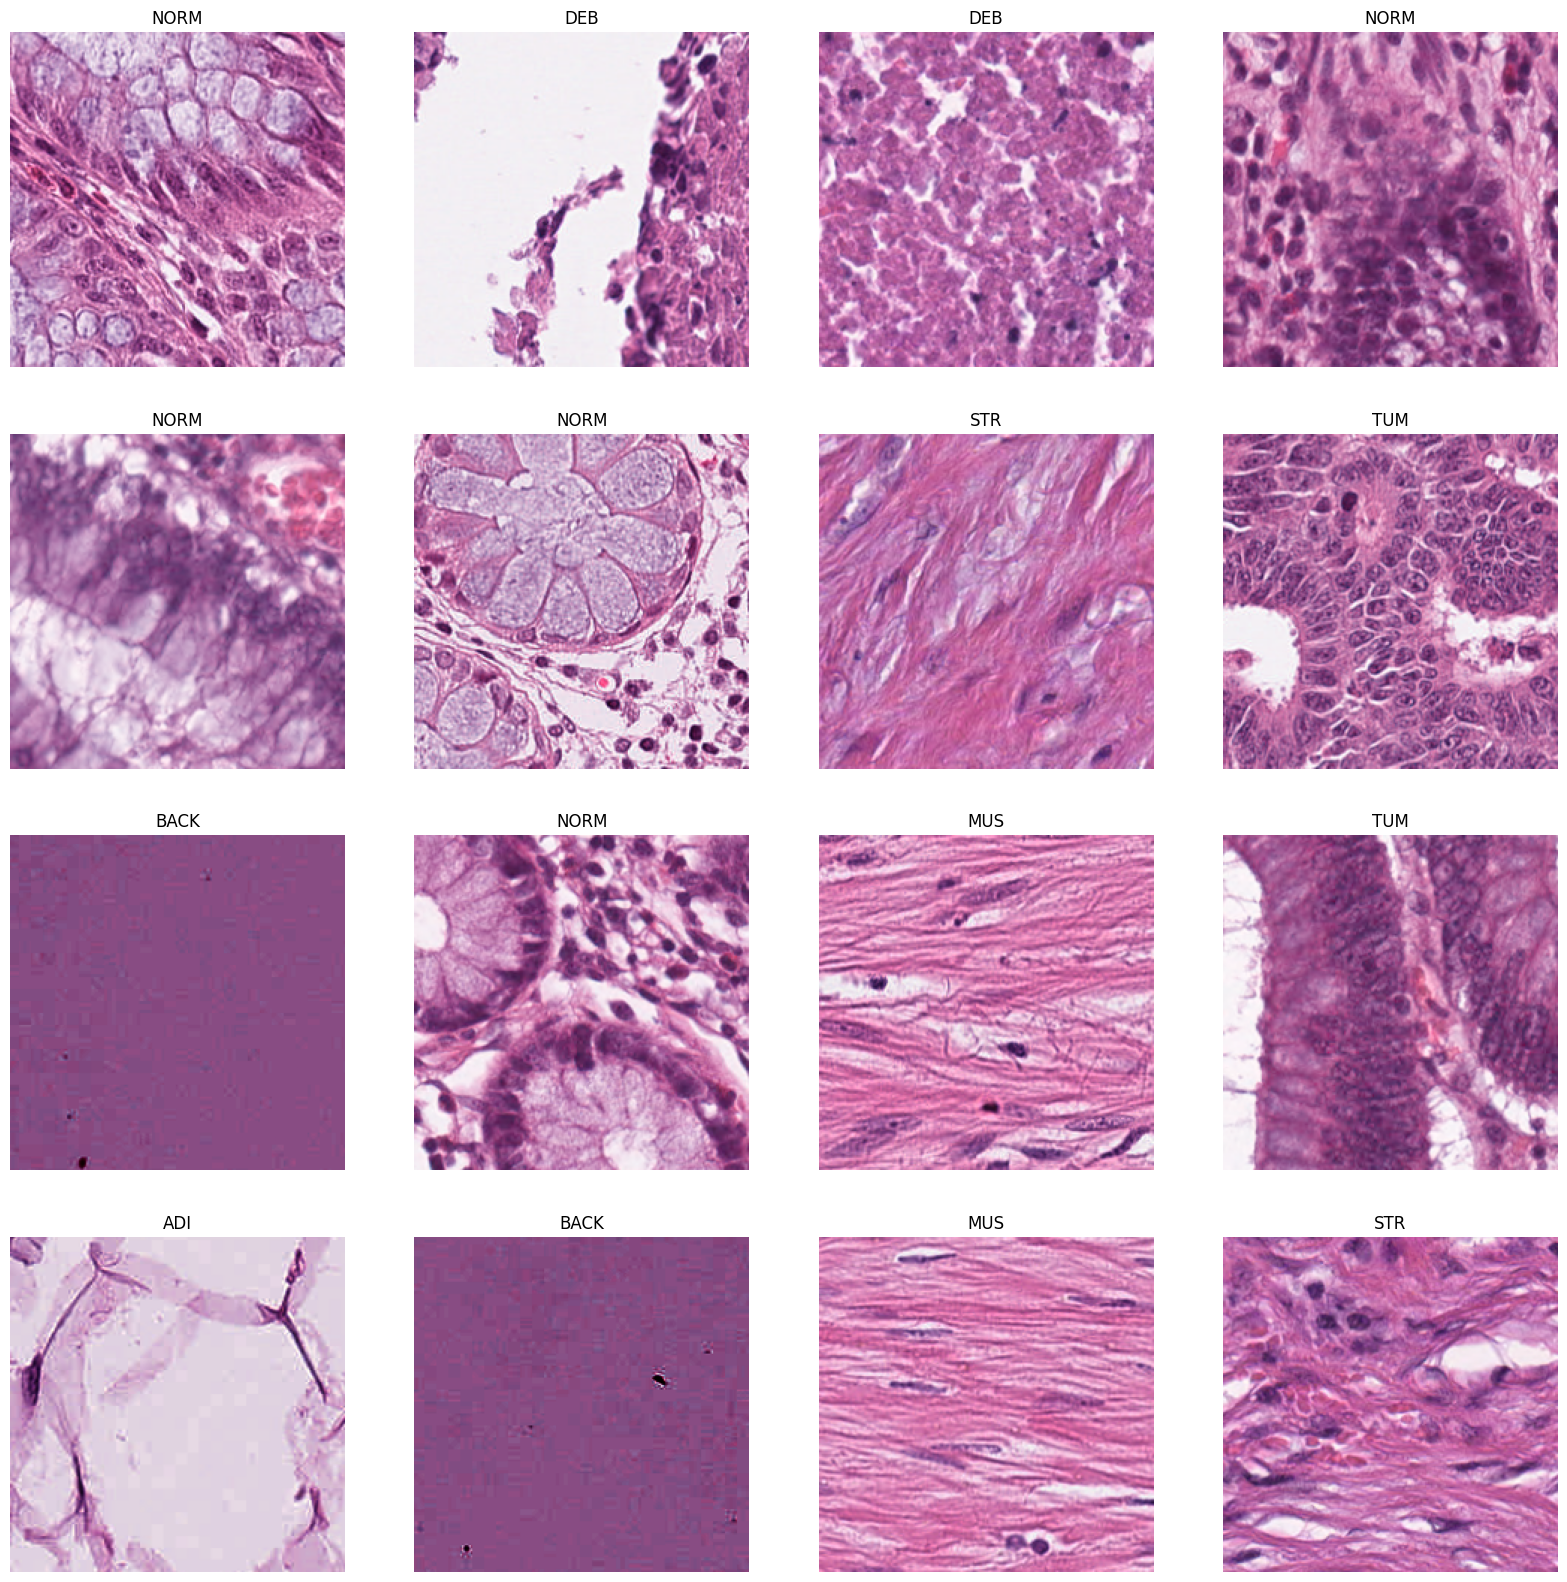

In [7]:
import matplotlib.pyplot as plt
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name)
    plt.axis('off')
plt.show()

In [18]:
from tensorflow.keras.layers import *
from tensorflow.keras import models

# Basic Block for ResNet-18 and ResNet-34
def basic_block(x, filters, stride=1):
    shortcut = x
    # 3x3 Convolution (Main path)
    x = Conv2D(filters, (3, 3), strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # 3x3 Convolution (Main path)
    x = Conv2D(filters, (3, 3), strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    
    # Shortcut connection
    if stride != 1 or shortcut.shape[-1] != filters:
        # Apply 1x1 Convolution to match dimensions of shortcut
        shortcut = Conv2D(filters, (1, 1), strides=stride, use_bias=False, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)  # Ensure batch normalization is here
    
    # Add shortcut and main path
    x = Add()([x, shortcut])
    x = ReLU()(x)
    
    return x


# Bottleneck Block for ResNet-50, ResNet-101, and ResNet-152
def bottleneck(x, filters, stride=1):
    shortcut = x

    # 1x1 Reduction
    x = Conv2D(filters // 4, (1, 1), strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # 3x3 Spatial Convolution
    x = Conv2D(filters // 4, (3, 3), strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # 1x1 Expansion
    x = Conv2D(filters, (1, 1), strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    # Shortcut Connection
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

# ResNet Model function
def resnet(block, layers_list, num_classes):
    inputs = Input(shape=(224, 224, 3))
    
    # Initial Convolution and MaxPooling
    x = Conv2D(64, (7, 7), strides=2, use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((3, 3), strides=2)(x)
    
    # Residual blocks
    filters = [64, 128, 256, 512]
    
    # Apply blocks according to the number of layers for each block
    for i in range(4):
        for j in range(layers_list[i]):
            stride = 2 if j == 0 and i > 0 else 1
            if block == basic_block:
                x = basic_block(x, filters[i], stride)  # For ResNet-18 and ResNet-34
            else:
                x = bottleneck(x, filters[i] * 4, stride)  # For deeper ResNets (50, 101, 152)
    
    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    
    # Fully connected layer for classification
    #outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = models.Model(inputs, x)
    return model



# Function to get the ResNet model based on the version
def get_resnet(version, num_classes):
    if version == 18:
        return resnet(basic_block, [2, 2, 2, 2], num_classes)
    elif version == 34:
        return resnet(basic_block, [3, 4, 6, 3], num_classes)
    elif version == 50:
        return resnet(bottleneck, [3, 4, 6, 3], num_classes)
    elif version == 101:
        return resnet(bottleneck, [3, 4, 23, 3], num_classes)
    elif version == 152:
        return resnet(bottleneck, [3, 8, 36, 3], num_classes)
    else:
        raise ValueError(f"ResNet version {version} not supported!")


In [19]:
from tensorflow.keras.optimizers import Adam,SGD,Adamax
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
base_model = get_resnet(18,9)
model = Sequential([
    base_model,
    Dense(256, kernel_regularizer=regularizers.l2(0.02), activation='relu'),
    Dropout(rate= 0.5),
    Dense(9, activation= 'softmax')
])

model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=10,
    validation_data=(valid_gen),
    callbacks=[early_stopping]
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 285s 430ms/step - accuracy: 0.7066 - loss: 6.8815 - val_accuracy: 0.7662 - val_loss: 5.0449
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 271s 430ms/step - accuracy: 0.9170 - loss: 4.1077 - val_accuracy: 0.8783 - val_loss: 3.1206
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 269s 425ms/step - accuracy: 0.9479 - loss: 2.5571 - val_accuracy: 0.8855 - val_loss: 2.0382
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 268s 425ms/step - accuracy: 0.9616 - loss: 1.5660 - val_accuracy: 0.8944 - val_loss: 1.3058
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 269s 426ms/step - accuracy: 0.9711 - loss: 0.9705 - val_accuracy: 0.8864 - val_loss: 1.0168
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 269s 425ms/step - accuracy: 0.9767 - loss: 0.6151 - val_accuracy: 0.8247 - val_loss: 1.0799
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 266s 422ms/step - accuracy: 0.9814 - loss: 0.4027 - val_accuracy: 0.7638 - val_loss: 1.1831
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 270s 427ms/step - accuracy: 0.9854 -

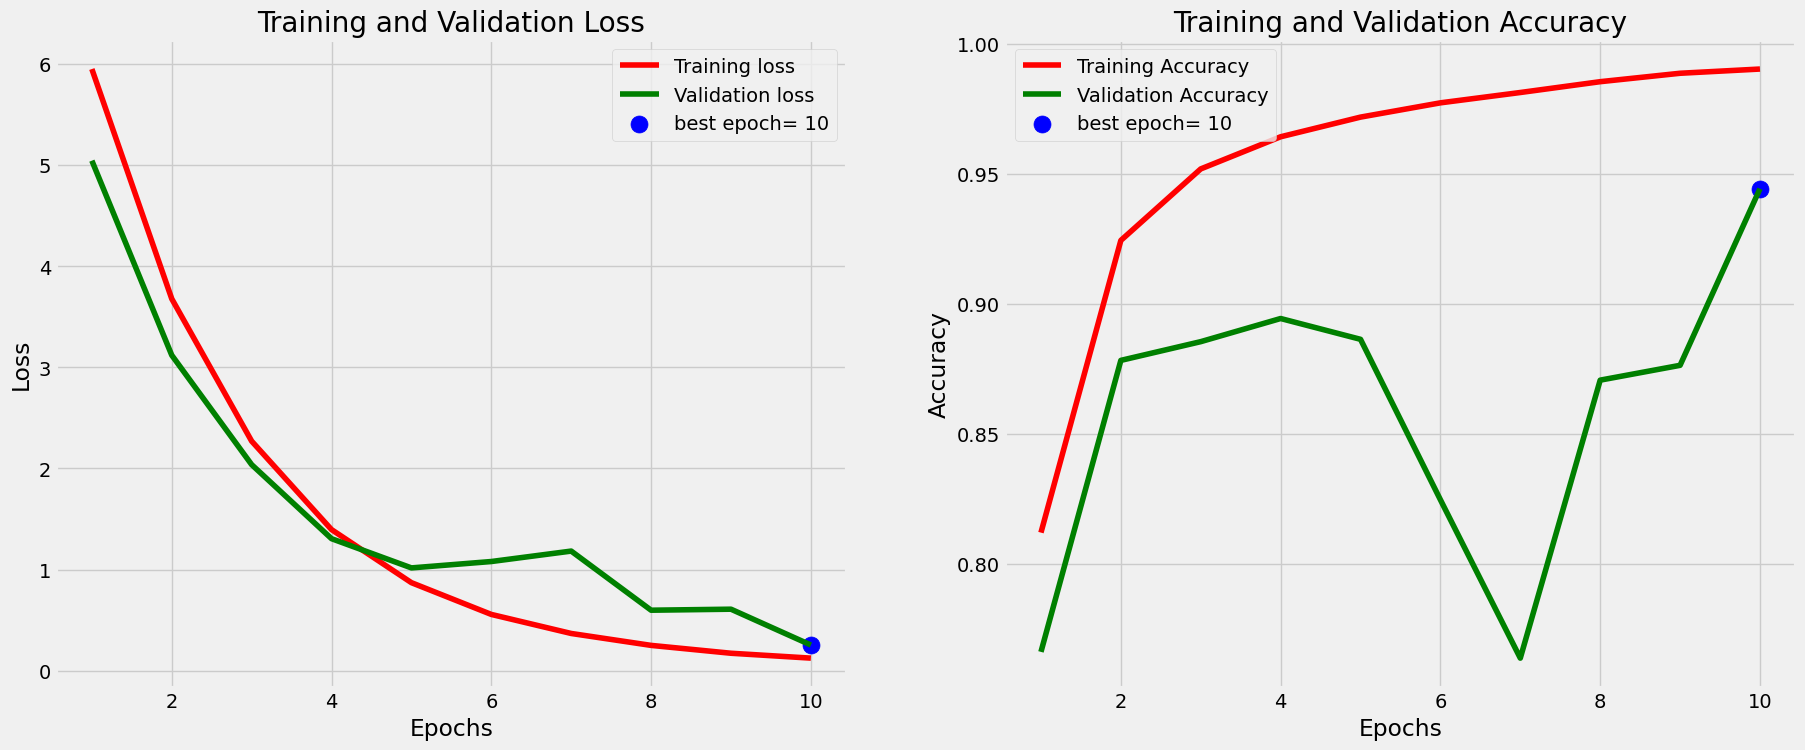

In [20]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [21]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 40)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 40)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 386ms/step - accuracy: 0.9578 - loss: 0.1976
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 237ms/step - accuracy: 0.9443 - loss: 0.2522


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 240ms/step - accuracy: 0.9467 - loss: 0.2519
Train Loss:  0.18836945295333862
Train Accuracy:  0.9615625143051147
----------------------------------------
Valid Loss:  0.25389599800109863
Valid Accuracy:  0.9442999958992004
----------------------------------------
Test Loss:  0.2564695179462433
Test Accuracy:  0.9466000199317932


In [22]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 387ms/step


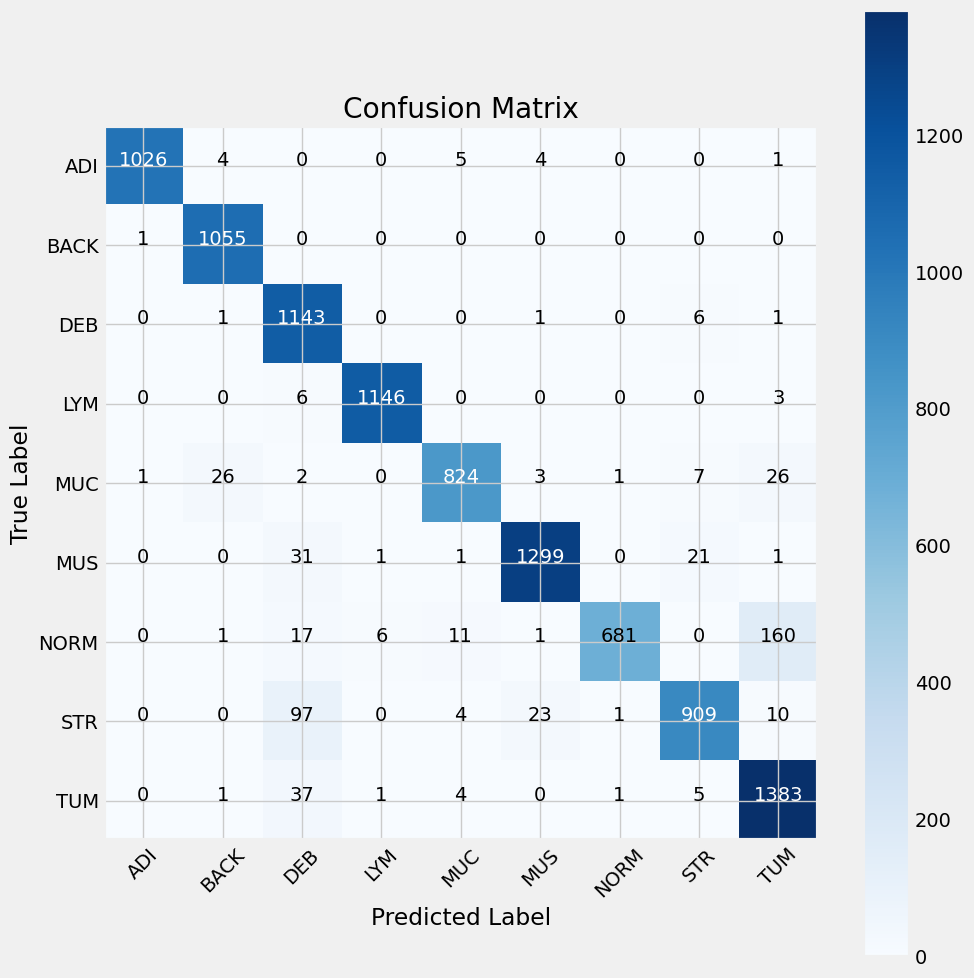

In [23]:
import itertools
from sklearn.metrics import confusion_matrix
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [24]:
from sklearn.metrics import classification_report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

         ADI       1.00      0.99      0.99      1040
        BACK       0.97      1.00      0.98      1056
         DEB       0.86      0.99      0.92      1152
         LYM       0.99      0.99      0.99      1155
         MUC       0.97      0.93      0.95       890
         MUS       0.98      0.96      0.97      1354
        NORM       1.00      0.78      0.87       877
         STR       0.96      0.87      0.91      1044
         TUM       0.87      0.97      0.92      1432

    accuracy                           0.95     10000
   macro avg       0.95      0.94      0.95     10000
weighted avg       0.95      0.95      0.95     10000



79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 375ms/step


/tmp/ipykernel_23/1647604500.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", n_classes)  # Color map for multiple classes


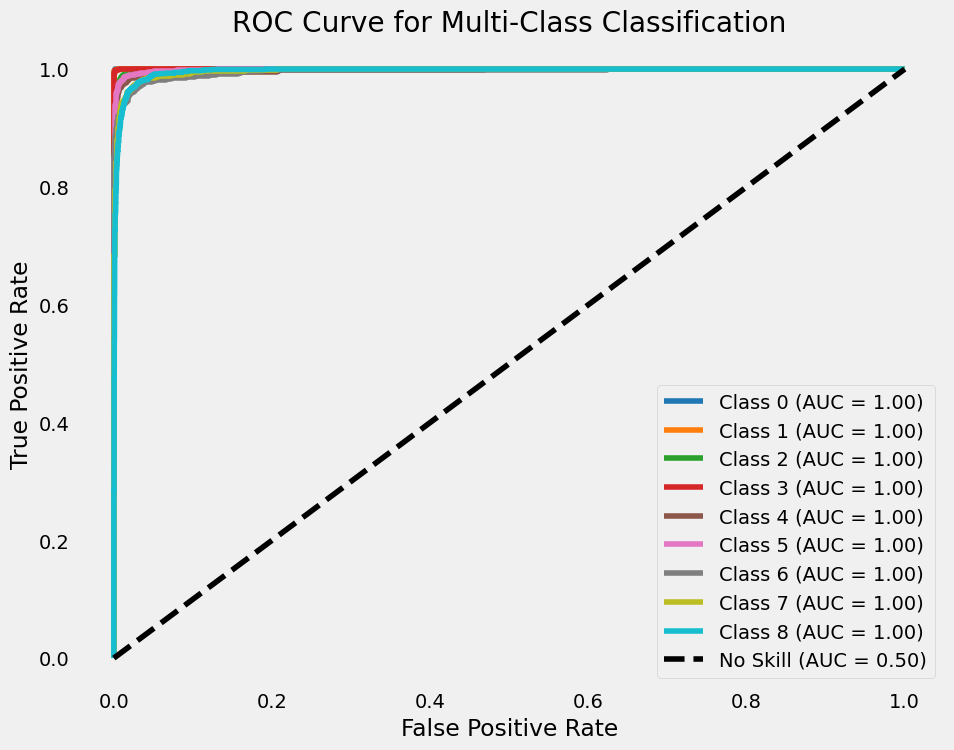

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Get predicted probabilities on the test set
y_pred = model.predict(test_gen)

# Get true labels from the test generator
y_true = test_gen.classes  # True class indices
y_true = np.eye(len(test_gen.class_indices))[y_true]  # Convert to one-hot-encoded format

# Number of classes
n_classes = y_true.shape[1]

# Initialize variables to store ROC curve data
fpr = dict()  # False Positive Rate
tpr = dict()  # True Positive Rate
roc_auc = dict()  # Area Under the Curve

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap("tab10", n_classes)  # Color map for multiple classes

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})", color=colors(i))

# Plot diagonal (no-skill classifier)
plt.plot([0, 1], [0, 1], 'k--', label="No Skill (AUC = 0.50)")

# Add plot labels and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Classification")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [26]:
model.save("model.h5")